In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Dictionary Attacks

In [3]:
import pikepdf
from colorama import Fore

In [4]:
pdf = pikepdf.Pdf.open('sample.pdf')    
pdf.save('protected.pdf', encryption=pikepdf.Encryption(owner = 'messi',user='messi'))
# you can change the R from 4 to 6 for 256 aes encryption
pdf.close()

In [10]:

# unzip rockyou zip file and open it here
file = open('C:/Users/jlutz/cmda4984/rockyou.txt')

In [11]:
for guess in file:
    try:
        pikepdf.open("protected.pdf",password = guess.strip())
        print(Fore.GREEN + 'Password Found: ' + guess )
        correct = guess
        break

    except:
        print(Fore.RED + 'Trying Passwords: '+ guess)
        continue

Trying Passwords: 123456

Trying Passwords: 12345

Trying Passwords: 123456789

Trying Passwords: password

Trying Passwords: iloveyou

Trying Passwords: princess

Trying Passwords: 1234567

Trying Passwords: rockyou

Trying Passwords: 12345678

Trying Passwords: abc123

Trying Passwords: nicole

Trying Passwords: daniel

Trying Passwords: babygirl

Trying Passwords: monkey

Trying Passwords: lovely

Trying Passwords: jessica

Trying Passwords: 654321

Trying Passwords: michael

Trying Passwords: ashley

Trying Passwords: qwerty

Trying Passwords: 111111

Trying Passwords: iloveu

Trying Passwords: 000000

Trying Passwords: michelle

Trying Passwords: tigger

Trying Passwords: sunshine

Trying Passwords: chocolate

Trying Passwords: password1

Trying Passwords: soccer

Trying Passwords: anthony

Trying Passwords: friends

Trying Passwords: butterfly

Trying Passwords: purple

Trying Passwords: angel

Trying Passwords: jordan

Trying Passwords: liverpool

Trying Passwords: justin

Tryin

In [24]:
cracked = pikepdf.open("protected.pdf",password = guess.strip())
page1 = cracked.pages[1]

In [25]:
imageKey = list(page1.images.keys())
imageKey

['/Image14']

In [26]:
rawimage = page1.images[imageKey[0]]

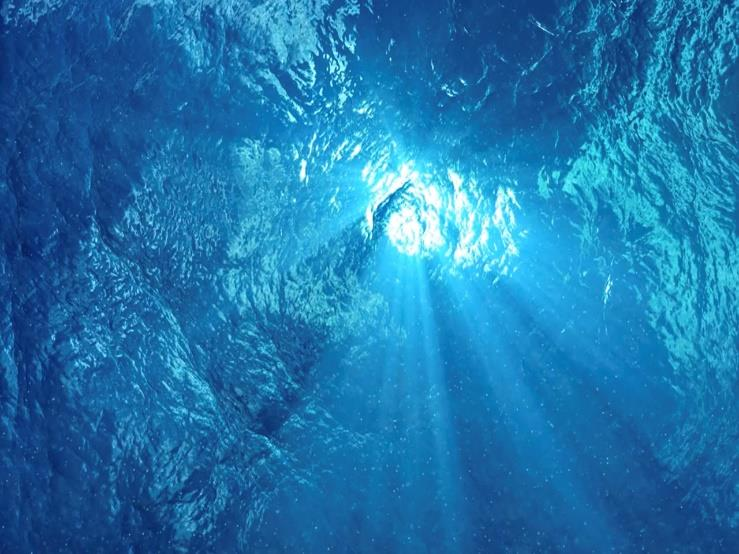

In [27]:
pdfimage = pikepdf.PdfImage(rawimage)
pdfimage

In [30]:
pdfimage.extract_to(fileprefix='image')

'image.jpg'